In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from src.utils.datasets.ggimages import OpenImage
from src.utils.datasets.transform import RandomHorizontalFlip, Resize, Compose, XyToCenter
import torchvision.transforms as transforms
from src.utils.display.images import imshow, result_show
from torch.utils.data import DataLoader
from src.utils.datasets.adapter import convert_data
import numpy as np
from src.network.yolo import Yolo
from src.config import VOC_ANCHORS
from src.utils.process_boxes import preprocess_true_boxes
from src.config import IOU_THRESHOLD, TENSORBOARD_PATH
from tensorboardX import SummaryWriter

writer = SummaryWriter(TENSORBOARD_PATH)



general_transform = Compose([
    Resize((608, 608)),
    XyToCenter()
])


transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225])
            ])

In [3]:
from torch.optim import SGD, RMSprop, Adam
from torch.optim.lr_scheduler import StepLR
from datetime import datetime
from src.utils.evaluate.metter import AverageMeter

In [4]:
batch_size = 1

ds = OpenImage('/data/data', 'OpenImage2', general_transform=general_transform, transform=transform)

train_data_loader = DataLoader(ds, batch_size=batch_size, shuffle=True, collate_fn=convert_data, num_workers=0)


In [5]:
from src.network.base import DarkNet, DarknetBody, YoloBody

model = Yolo(VOC_ANCHORS, ds.classes)
model.cuda()
model.train()

Yolo(
  (yolo_body): YoloBody(
    (body_bottom): DarknetBodyBottom(
      (first_layer): Conv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.1)
      )
      (second_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (third_layer): Conv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.1)
      )
      (forth_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (fifth_layer): BottleneckBlock(
        (first_layer): Conv2d(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(128, ep

In [29]:
params = filter(lambda x: x.requires_grad, model.parameters())
optimizer = SGD(model.parameters(), lr = 0.0001, momentum=0.9)
# optimizer = RMSprop(model.parameters(), lr=1e-5, momentum=0.9, weight_decay=0.00005)?
exp_lr_scheduler = StepLR(optimizer, step_size=100, gamma=0.9)

In [30]:
def train(data_gen ,model, metters, optimizer, lr_scheduler, current_epoch=0):
    
    steps_per_epoch = len(data_gen) 
    model.train()
    train_loss = metters
    for step, blobs in enumerate(data_gen):
        batch_tensor, batch_boxes, detectors_mask, matching_true_boxes, im_info, img_name = blobs
        batch_tensor = batch_tensor.to(torch.device('cuda'))
        detectors_mask = detectors_mask.to(torch.device('cuda'))
        matching_true_boxes = matching_true_boxes.to(torch.device('cuda'))
        batch_boxes = batch_boxes.to(torch.device('cuda'))

        output = model(batch_tensor)
        loss = model.loss(output, batch_boxes, detectors_mask, matching_true_boxes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        train_loss.update(loss.item())     

        current_step = current_epoch * steps_per_epoch + step
        if step % 10 == 1:
            print(loss.item())

            log_text = 'epoch: %d : step %d,  loss: %.4f at %s' % (
                current_epoch + 1, step , train_loss.avg, datetime.now().strftime('%m/%d_%H:%M'))
            print(log_text)


In [31]:
train_loss = AverageMeter()
for i in range(60):
    train(train_data_loader ,model, train_loss, optimizer, exp_lr_scheduler, i)


/opt/conda/envs/pytorch/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


326.6385803222656
epoch: 1 : step 1,  loss: 388.9303 at 04/09_03:50
26.361103057861328
epoch: 1 : step 11,  loss: 142.7697 at 04/09_03:50
37.15054702758789
epoch: 2 : step 1,  loss: 132.9488 at 04/09_03:50
78.01191711425781
epoch: 2 : step 11,  loss: 111.2662 at 04/09_03:50
206.7927703857422
epoch: 3 : step 1,  loss: 120.8600 at 04/09_03:50
227.77491760253906
epoch: 3 : step 11,  loss: 110.9410 at 04/09_03:50
26.558481216430664
epoch: 4 : step 1,  loss: 106.8785 at 04/09_03:50
33.51253890991211
epoch: 4 : step 11,  loss: 102.8060 at 04/09_03:50
92.67425537109375
epoch: 5 : step 1,  loss: 106.7554 at 04/09_03:50
78.75689697265625
epoch: 5 : step 11,  loss: 105.8815 at 04/09_03:50
76.51596069335938
epoch: 6 : step 1,  loss: 101.2233 at 04/09_03:50
204.17771911621094
epoch: 6 : step 11,  loss: 98.5796 at 04/09_03:50
25.52401351928711
epoch: 7 : step 1,  loss: 98.4353 at 04/09_03:50
55.40602493286133
epoch: 7 : step 11,  loss: 95.4010 at 04/09_03:50
67.56175994873047
epoch: 8 : step 1,  lo

In [214]:
data = next(iter(train_data_loader))
batch_tensor, batch_boxes, detectors_mask, matching_true_boxes, im_info, img_name = data
# batch_tensor, im_info, batch_boxes, batch_boxes_index, img_name = data

[0.61621094 0.19106881 0.2078942  0.5686597 ]
[ 0.7519531   0.13030747 -0.36924866  0.04283608]
[0.70166016 0.32430455 0.12565611 0.73928523]
[ 0.7890625   0.20204978  0.25918752 -0.01448657]
[ 0.7133789   0.39385065  0.11077145 -0.06719185]
[ 0.99560547  0.215959   -0.41066083 -0.22845182]
[0.9790039  0.99048316 0.42045566 0.6141221 ]
[ 0.9067383   0.86237186 -0.41066083 -0.17885488]
[0.47851562 0.39385065 0.25918752 0.636101  ]


[[ 72.4375   210.9751    95.       249.2533  ]
 [ 76.       267.05713  292.125    573.2826  ]
 [108.0625    83.677895 128.84375  129.0776  ]
 [173.375    155.78331  197.125    177.14787 ]
 [251.15625   26.705719 370.5      190.50073 ]
 [363.96875  140.65007  403.75     193.17131 ]
 [401.375     75.66618  429.28125  115.72475 ]
 [425.125      0.       464.90625   55.191803]
 [547.4375    88.128845 571.1875   129.0776  ]]


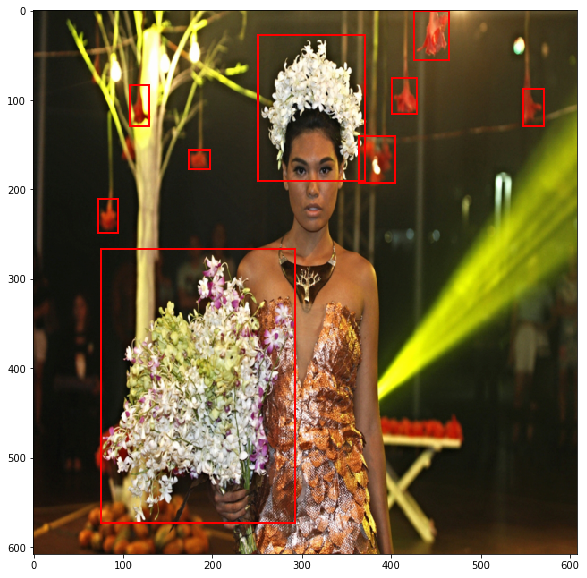

In [215]:
from src.utils.display.images import imshow, result_show
for k in range(batch_tensor.shape[0]):
    current_im_info = im_info[k]
    tmp = batch_boxes[k] * torch.Tensor([current_im_info[0], current_im_info[1], current_im_info[0], current_im_info[1], 1])
    tmp = tmp.numpy()        
    between = tmp[:, 2:4] / 2        
    xy = tmp[:, :2]
    xy_min = xy - between
    xy_max = xy + between
    print(np.hstack((xy_min, xy_max)))
    imshow(batch_tensor[k], gt_boxes=np.hstack((xy_min, xy_max)))
    break

In [216]:
writer.add_graph(model, batch_tensor.to(torch.device('cuda')))

batch_tensor.shape

/data/src/network/base.py:175: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert(H % stride == 0)
/data/src/network/base.py:176: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert(W % stride == 0)


torch.Size([1, 3, 608, 608])

In [217]:
model.train()
batch_tensor = batch_tensor.to(torch.device('cuda'))
detectors_mask = detectors_mask.to(torch.device('cuda'))
matching_true_boxes = matching_true_boxes.to(torch.device('cuda'))
batch_boxes = batch_boxes.to(torch.device('cuda'))

output = model(batch_tensor)
loss = model.loss(output, batch_boxes, detectors_mask, matching_true_boxes)
print(loss.item())

0.07719855010509491
0.09598810225725174
0.16980493068695068
0.1593746840953827
0.502366304397583


In [218]:
model.train()
boxes, scores, classes = model.predict(batch_tensor)

torch.Size([1, 40, 19, 19])
torch.Size([1, 5, 2, 19, 19])
torch.Size([1, 5, 2, 19, 19])


In [219]:
print(boxes)

tensor([[396.3087,  69.6172, 424.3887, 109.7241],
        [106.1195,  84.0313, 126.9133, 129.5457],
        [550.0076,  89.0648, 573.8657, 130.6828],
        [171.2217, 158.1272, 194.9207, 179.5541],
        [ 73.2430, 212.6815,  95.8298, 251.0858],
        [423.0214,  -3.5987, 462.5329,  51.5958],
        [359.6731, 144.1196, 399.4948, 196.5305],
        [251.3135,  28.5936, 370.5188, 192.4014],
        [ 73.5421, 271.4701, 289.6292, 577.2263]], device='cuda:0',
       grad_fn=<IndexBackward>)


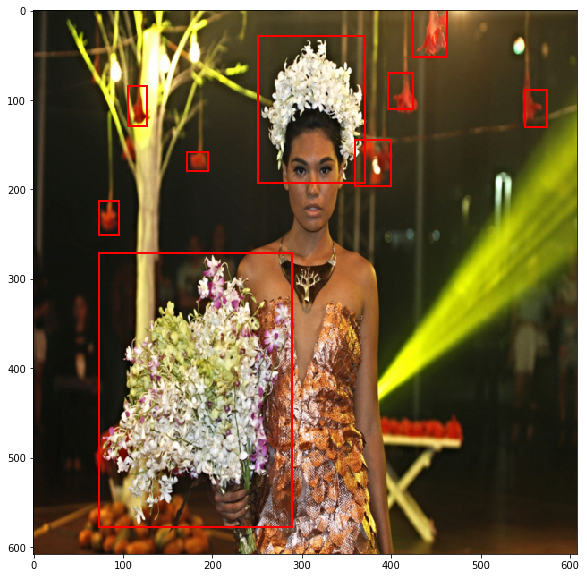

In [220]:
for k in range(batch_tensor.shape[0]):
    current_im_info = im_info[k]
    tmp = boxes.cpu()
    tmp = tmp.detach().numpy()       
    imshow(batch_tensor[k].cpu(), gt_boxes=tmp)
    break